In [1]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara
-- exclude non-standard CCG codes:
WHERE SUBSTR(pct,1,1) NOT BETWEEN 'A' AND 'Z' -- first character numerical
AND SUBSTR(pct,3,1) BETWEEN 'A' AND 'Z'  -- last character alphabetical
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

## Clean the data: sort out null denominators

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)


### Filter out low numbers (chemical and subpara)

In [3]:
# total prescribing for each chemical
#sum numerators to find total volume for each chemical
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))
num.head()

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))
data3 = data3.loc[(data3["denom centile"]>2) & (data3["num centile"]>2)]
data3.head()

pct  subpara  denom_subpara   chemical    num  denom     ratio  num_total  \
0  10C  1202030          203.0  1202030R0   35.0  203.0  0.172414      21681   
1  10D  1202030          210.0  1202030R0   23.0  210.0  0.109524      21681   
2  10E  1202030          216.0  1202030R0   27.0  216.0  0.125000      21681   
3  10G  1202030          320.0  1202030R0   32.0  320.0  0.100000      21681   
4  10H  1202030          753.0  1202030R0  144.0  753.0  0.191235      21681   

   num centile  denom_subpara_total  denom centile  
0            7             117303.0              5  
1            7             117303.0              5  
2            7             117303.0              5  
3            7             117303.0              5  
4            7             117303.0              5

## Calculate key stats
### Median, Range, SD

In [4]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile"])["ratio"].describe())
df2 = df2.unstack()
df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","50%","min","max","range","std"]].rename(columns={"50%":"median"})

# filter out chemicals only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]
df3.head()

chemical  subpara  num_total  num centile  denom_subpara_total  \
0  0101010C0  0101010       1423            5              39497.0   
1  0101010F0  0101010        119            3              39497.0   
2  0101010G0  0101010      19759            7              39497.0   
3  0101010I0  0101010       1050            4              39497.0   
4  0101010J0  0101010        984            4              39497.0   

   denom centile  count    median       min       max     range       std  
0              4  192.0  0.013179  0.000000  0.340426  0.340426  0.069412  
1              4  192.0  0.000000  0.000000  0.185629  0.185629  0.017496  
2              4  192.0  0.440633  0.081081  0.912442  0.831361  0.186258  
3              4  192.0  0.016001  0.000000  0.294872  0.294872  0.049069  
4              4  192.0  0.018857  0.000000  0.162162  0.162162  0.027994

### Kurtosis & Skew 
Need to import stats module and reshape data

In [5]:
# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")


### Compile stats up

In [6]:

result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"]].round(2)
df4.head()

C:\Users\hcurtis\Anaconda2\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


chemical          chemical name  subpara  \
0  0501012G0  Flucloxacillin Sodium  0501012   
1  0109040N0             Pancreatin  0109040   
2  1404000AP                    NaN  1404000   
3  0405010P0               Orlistat  0405010   
4  0402010C0              Clozapine  0402010   

                           subpara name  num_total  num centile  count  \
0   Penicillinase-Resistant Penicillins  1058061.0         10.0  207.0   
1                            Pancreatin   131281.0          9.0  207.0   
2                 Vaccines And Antisera      155.0          3.0  207.0   
3  Gastro-Intestinal Anti-Obesity Drugs   106235.0          9.0  203.0   
4                   Antipsychotic Drugs      768.0          4.0  207.0   

   median   min   max  range  std  kurtosis   skew  
0     1.0  1.00  1.00   0.00  0.0    202.00 -14.28  
1     1.0  1.00  1.00   0.00  0.0    202.00 -14.28  
2     0.0  0.00  0.05   0.05  0.0    194.36  13.90  
3     1.0  0.99  1.00   0.01  0.0    176.71 -13.11  
4     0.0  0.00  0.02   0.02  0.0    172.99  12.82

## Ranking Chemicals by Range, Kurtosis, Skew and SD

In [7]:
# sort by range first
r1 = df4.sort_values(by=["range","kurtosis"],ascending=False).head(20)
# create a flag
r1["R"] = 1

# sort by kurtosis and limit to items with at least 1% range 
r2 = df4.loc[(df4["range"] >0.1)].sort_values(by=["kurtosis"],ascending=False).head(20)
r2["K"] = 1

# sort by skew
r3 = df4.loc[(df4["range"] >0.1)].sort_values(by=["skew"],ascending=False).head(20)
r3["Sk"] = 1

#sort by SD
r4 = df4.loc[(df4["range"] >0.1)].sort_values(by=["std"],ascending=False).head(20)
r4["SD"] = 1
r4

chemical                             chemical name  subpara  \
1125  0208010D0                                Enoxaparin  0208010   
933   1501030G0                    Glycopyrronium Bromide  1501030   
932   1501030H0                     Hyoscine Hydrobromide  1501030   
1124  0208010L0                         Dalteparin Sodium  0208010   
819   0208010W0                         Tinzaparin Sodium  0208010   
1119  0301040W0              Umeclidinium Brom/Vilanterol  0301040   
1112  1302020D0                      Dimeticone (Barrier)  1302020   
1108  0905022C0                           Calcium Acetate  0905022   
1027  0905022S0                                 Sevelamer  0905022   
917   0410030C0                   Methadone Hydrochloride  0410030   
1114  0905013G0                Magnesium Glycerophosphate  0905013   
1113  0905013A0                       Magnesium Aspartate  0905013   
803   0906011D0                                 Vitamin A  0906011   
962   1310011M0                                 Mupirocin  1310011   
1092  0301030S0                              Theophylline  0301030   
1093  0301030C0                     Aminophylline Hydrate  0301030   
1096  0101010G0  Co-Magaldrox(Magnesium/Aluminium Hydrox)  0101010   
809   0906011H0                             Cod Liver Oil  0906011   
1107  110802070                      Ketorolac Trometamol  1108020   
1111  1302020E0                                Zinc Oxide  1302020   

                                  subpara name  num_total  num centile  count  \
1125                 Parenteral Anticoagulants    44906.0          8.0  204.0   
933                       Antimuscarinic Drugs    14241.0          7.0  108.0   
932                       Antimuscarinic Drugs     5035.0          6.0  108.0   
1124                 Parenteral Anticoagulants    33908.0          8.0  204.0   
819                  Parenteral Anticoagulants    17389.0          7.0  204.0   
1119      Compound Bronchodilator Preparations    83940.0          8.0  205.0   
1112                      Barrier Preparations    79048.0          8.0  207.0   
1108                  Phosphate Binding Agents    17193.0          7.0  196.0   
1027                  Phosphate Binding Agents    20729.0          7.0  196.0   
917                          Opioid Dependence   108891.0          9.0  176.0   
1114                                 Magnesium     9403.0          6.0  156.0   
1113                                 Magnesium     7170.0          6.0  156.0   
803                                  Vitamin A    12827.0          7.0  149.0   
962    Antibacterial Preps Only Used Topically    17452.0          7.0  189.0   
1092                              Theophylline   128528.0          9.0  207.0   
1093                              Theophylline    77621.0          8.0  207.0   
1096                   Antacids and Simeticone    19759.0          7.0  192.0   
809                                  Vitamin A     4702.0          6.0  149.0   
1107  Ocular Diagnos/Peri-op Prepn&Photodyn Tt    11720.0          6.0  175.0   
1111                      Barrier Preparations    73224.0          8.0  207.0   

      median   min   max  range   std  kurtosis  skew  SD  
1125    0.34  0.00  1.00   0.99  0.36     -1.62  0.23   1  
933     0.96  0.00  1.00   1.00  0.34      0.17 -1.34   1  
932     0.03  0.00  1.00   1.00  0.34      0.17  1.35   1  
1124    0.16  0.00  0.98   0.98  0.33     -1.18  0.66   1  
819     0.04  0.00  0.98   0.98  0.28      0.91  1.54   1  
1119    0.37  0.00  0.93   0.92  0.24     -1.01  0.19   1  
1112    0.34  0.02  0.91   0.89  0.23     -0.80  0.43   1  
1108    0.44  0.00  0.96   0.96  0.22     -0.70 -0.02   1  
1027    0.41  0.01  0.97   0.96  0.21     -0.23  0.49   1  
917     0.61  0.00  0.95   0.95  0.20      0.27 -0.80   1  
1114    0.51  0.09  0.97   0.88  0.20     -0.89  0.08   1  
1113    0.39  0.00  0.84   0.84  0.20     -0.82  0.09   1  
803     0.79  0.13  1.00   0.87  0.19      1.02 -1.13 

### Results compiled and with Hyperlinks to maps

In [14]:
# compile top 20 from each sort into a single output

rc = pd.merge(r1, r2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer").fillna(0)  

rc["score"] = rc["R"]+rc["K"]+rc["Sk"]+rc["SD"]
rc = rc.sort_values(by=["score","range","kurtosis"],ascending=False)


links = rc
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

### Histograms

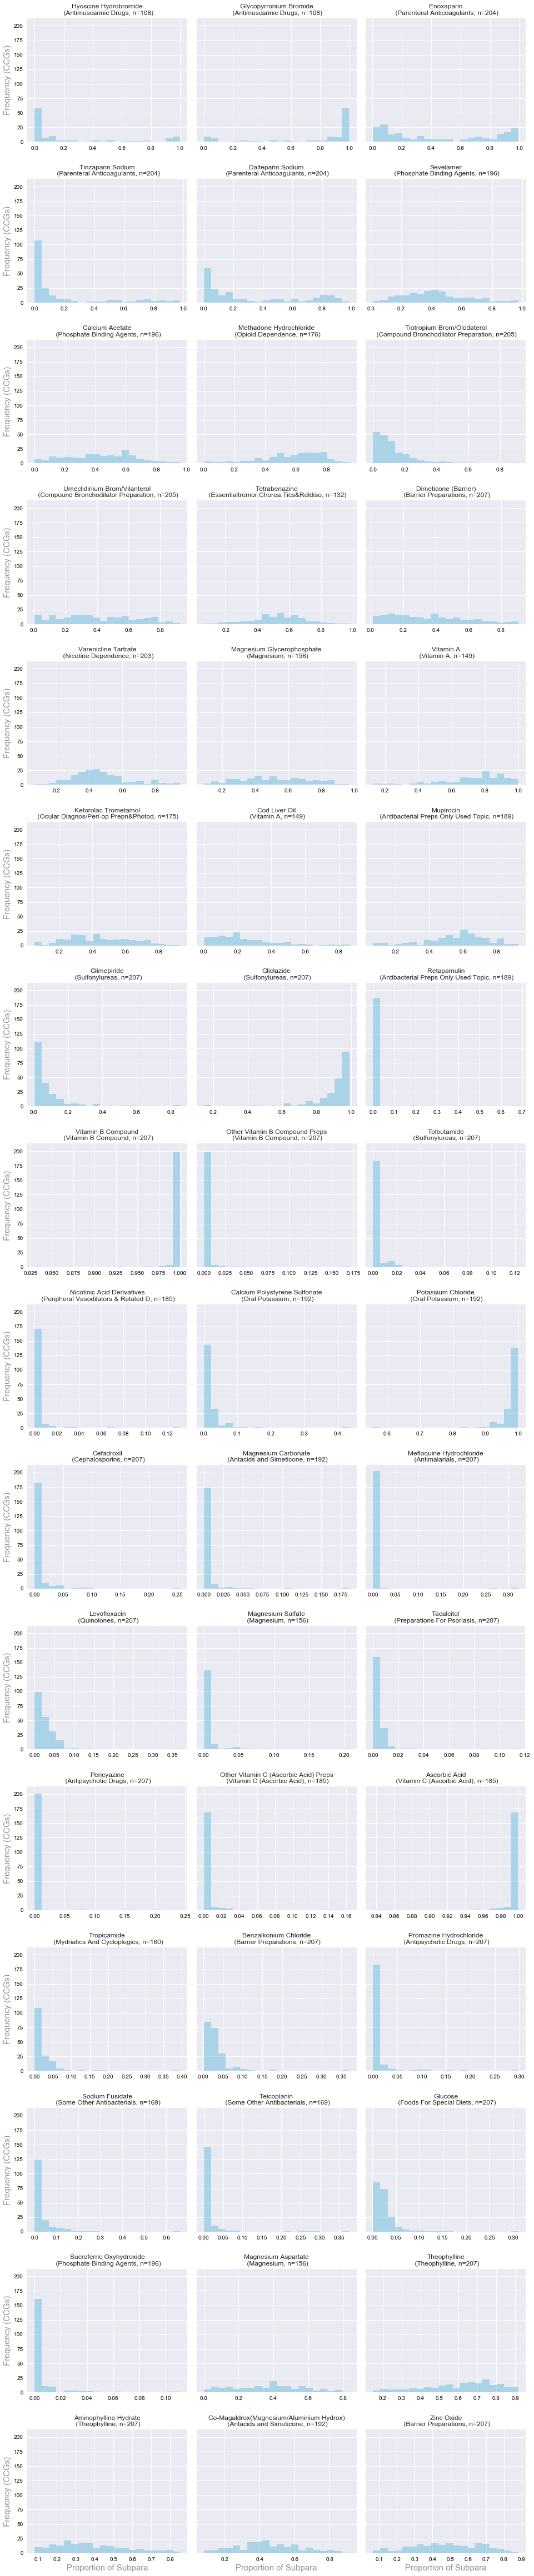

In [76]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+"\n"+" ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Histograms for top 40 chemicals by Kurtosis

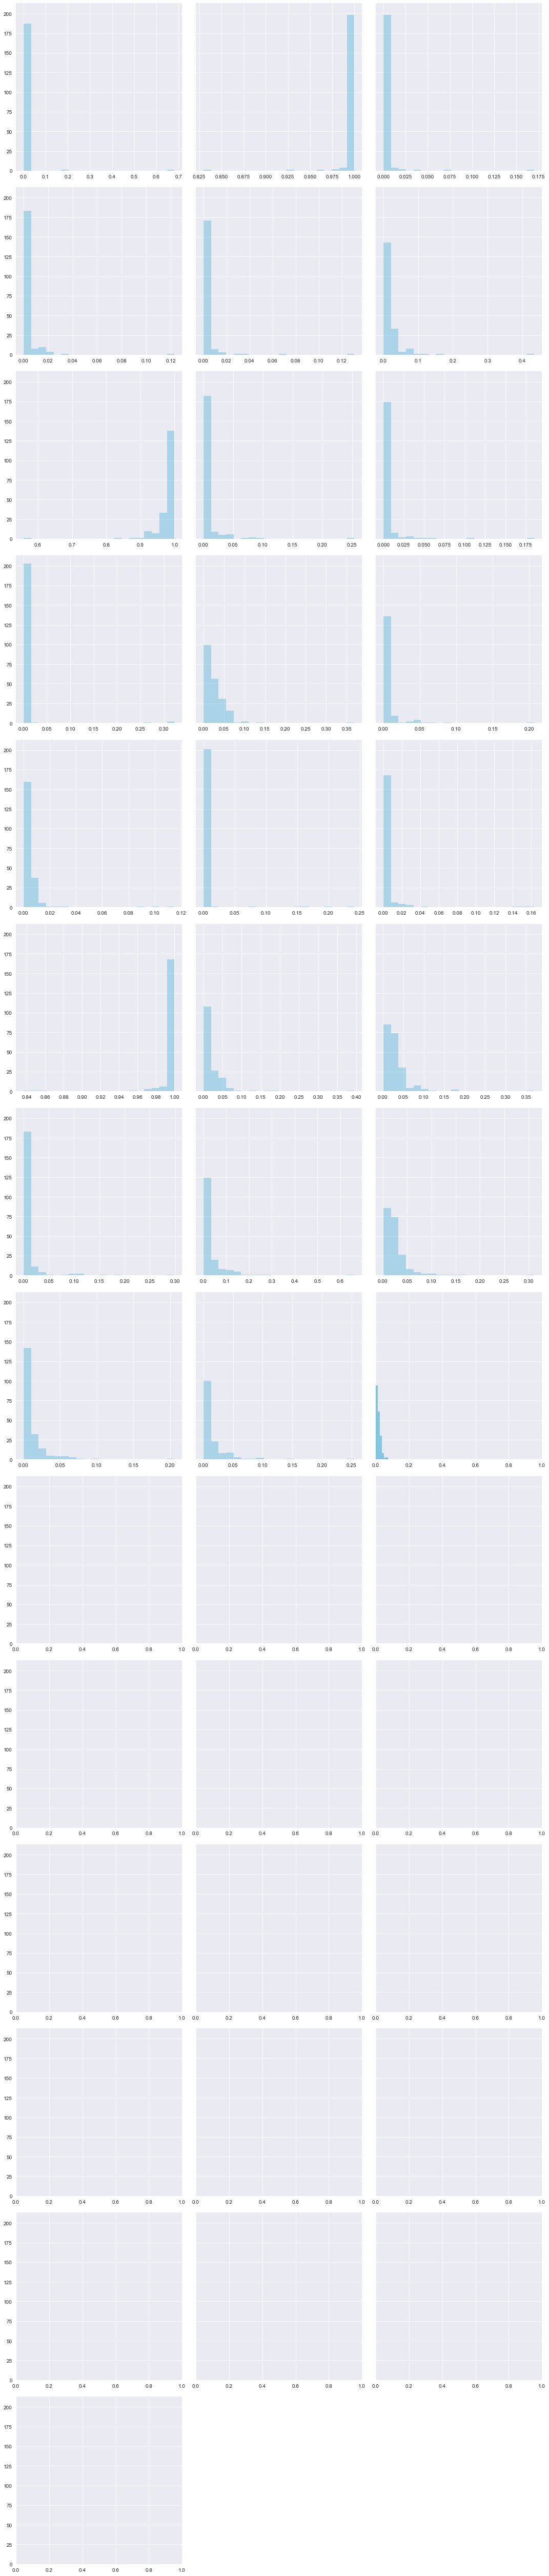

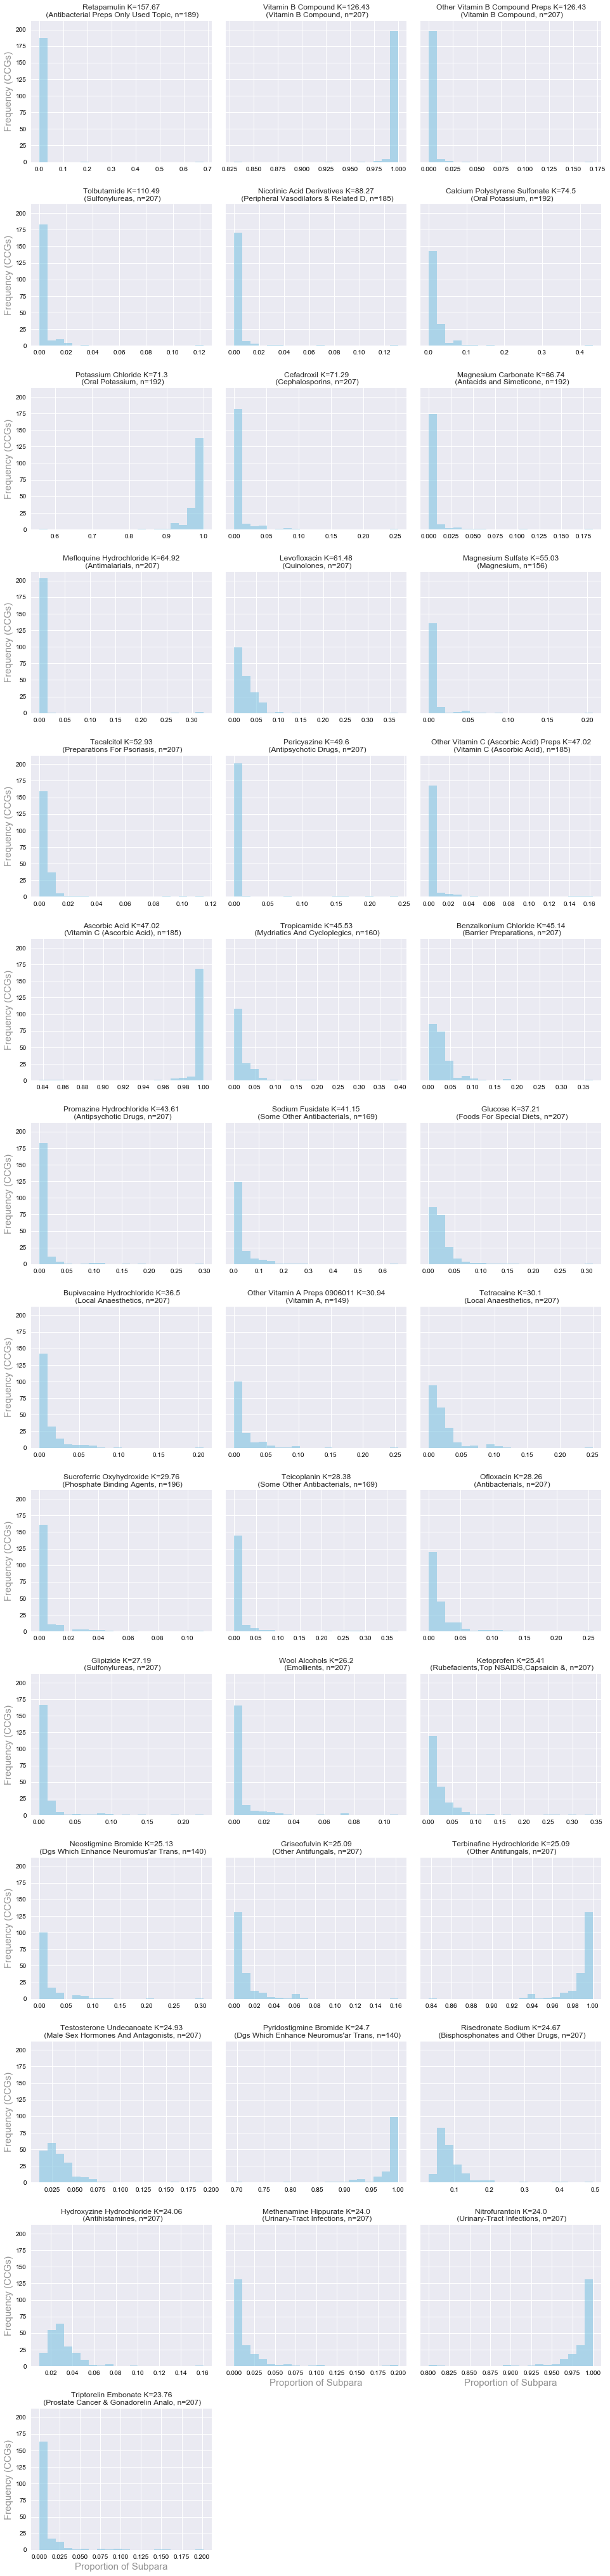

In [52]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = df4.loc[(df4["range"] >0.1)].sort_values(by=["kurtosis"],ascending=False).head(40)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Paragraph Rankings
Which paragraphs occur most often in the list of interesting chemicals?

In [54]:
para = rc.groupby(["subpara","subpara name"])["score"].agg(["count","sum"]).sort_values(by=["count","sum"],ascending=False)
para.loc[para["count"]>1]

count  sum
subpara subpara name                                       
0208010 Parenteral Anticoagulants                    3  6.0
0905013 Magnesium                                    3  5.0
0905022 Phosphate Binding Agents                     3  5.0
1302020 Barrier Preparations                         3  5.0
0601021 Sulfonylureas                                3  4.0
0402010 Antipsychotic Drugs                          2  4.0
0906011 Vitamin A                                    2  4.0
1310011 Antibacterial Preps Only Used Topically      2  4.0
1501030 Antimuscarinic Drugs                         2  4.0
0101010 Antacids and Simeticone                      2  3.0
0301040 Compound Bronchodilator Preparations         2  3.0
0501070 Some Other Antibacterials                    2  3.0
0902011 Oral Potassium                               2  3.0
0906027 Vitamin B Compound                           2  3.0
0906031 Vitamin C (Ascorbic Acid)                    2  3.0
0301030 Theophylline                                 2  2.0

## CCG Rankings
### Ranking CCGs for the list of interesting chems only, by Distance from Median

In [18]:
dftest = rc[["chemical","chemical name","subpara name","min","max","range","median"]].merge(data3, on="chemical")
#dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
dftest["abs diff"] = abs(dftest["ratio"]-dftest["median"])/dftest["range"]
dftest["rank abs diff"] = dftest.groupby(["chemical"])["abs diff"].rank(pct=True)
dftest.sort_values(by=["chemical","rank abs diff"])

#x0 = dftest.loc[(dftest["rank abs diff"]<=0.05)]# & (dftest["median"]>0)]
x1 = dftest.loc[(dftest["rank abs diff"]>=0.95)]# & (dftest["median"]<1)] 
x2 = x1#x0.append(x1)
x2 = x2.groupby("pct")["abs diff"].agg(["count","mean"])
x2.sort_values(by=["count","mean"],ascending=False).head(12)



count      mean
pct                 
00T      9  0.527743
02W      7  0.668962
08H      7  0.454670
07L      7  0.348686
01A      6  0.661089
02R      6  0.573655
06M      6  0.543001
02N      6  0.494352
08E      6  0.425479
11N      6  0.386538
08V      6  0.375819
07M      6  0.343425

### Investigate example CCG

In [21]:
x3 = x1[["pct","chemical"]].merge(dftest, how="inner", on=["pct","chemical"]).drop(["subpara","denom","range"], axis=1)
x3.loc[x3["pct"]=="00T"].sort_values(by=["rank abs diff","abs diff"],ascending=False)

pct   chemical                          chemical name  \
210  00T  0402010S0                Promazine Hydrochloride   
343  00T  0601021A0                            Glimepiride   
354  00T  0601021M0                             Gliclazide   
181  00T  0501120X0                           Levofloxacin   
272  00T  090603100  Other Vitamin C (Ascorbic Acid) Preps   
457  00T  0906031C0                          Ascorbic Acid   
112  00T  110802070                   Ketorolac Trometamol   
2    00T  1501030H0                  Hyoscine Hydrobromide   
8    00T  1501030G0                 Glycopyrronium Bromide   

                                 subpara name   min   max  median  \
210                       Antipsychotic Drugs  0.00  0.30    0.00   
343                             Sulfonylureas  0.00  0.85    0.04   
354                             Sulfonylureas  0.14  0.99    0.94   
181                                Quinolones  0.00  0.37    0.02   
272                 Vitamin C (Ascorbic Acid)  0.00  0.16    0.00   
457                 Vitamin C (Ascorbic Acid)  0.84  1.00    1.00   
112  Ocular Diagnos/Peri-op Prepn&Photodyn Tt  0.05  0.93    0.42   
2                        Antimuscarinic Drugs  0.00  1.00    0.03   
8                        Antimuscarinic Drugs  0.00  1.00    0.96   

     denom_subpara     num     ratio      rank  abs diff  rank abs diff  
210        18602.0  5555.0  0.298624  1.000000  0.995413       1.000000  
343        12636.0  5822.0  0.460747  0.980676  0.494997       0.980676  
354        12636.0  6748.0  0.534030  0.024155  0.477612       0.980676  
181          670.0    50.0  0.074627  0.980676  0.147640       0.980676  
272           74.0     2.0  0.027027  0.978378  0.168919       0.978378  
457           74.0    72.0  0.972973  0.027027  0.168919       0.978378  
112          133.0     7.0  0.052632  0.005714  0.422263       0.971429  
2            107.0   104.0  0.971963  0.962963  0.941963       0.962963  
8            107.0     3.0  0.028037  0.046296  0.931963       0.962963

## 99P

In [20]:
dftest.loc[dftest["pct"]=="99P"].sort_values(by=["rank abs diff"],ascending=False).head(12)

chemical             chemical name  \
3380  0501120X0              Levofloxacin   
4609  0905013N0         Magnesium Sulfate   
2661  1310011AA               Retapamulin   
19    1501030H0     Hyoscine Hydrobromide   
127   1501030G0    Glycopyrronium Bromide   
2846  0501070N0           Sodium Fusidate   
8841  0905022W0  Sucroferric Oxyhydroxide   
2145  110802070      Ketorolac Trometamol   
5547  0601021X0               Tolbutamide   
6146  0409030C0             Tetrabenazine   
8063  0501070T0               Teicoplanin   
4415  0402010P0               Pericyazine   

                                  subpara name   min   max  range  median  \
3380                                Quinolones  0.00  0.37   0.37    0.02   
4609                                 Magnesium  0.00  0.21   0.21    0.00   
2661   Antibacterial Preps Only Used Topically  0.00  0.68   0.68    0.00   
19                        Antimuscarinic Drugs  0.00  1.00   1.00    0.03   
127                       Antimuscarinic Drugs  0.00  1.00   1.00    0.96   
2846                 Some Other Antibacterials  0.00  0.66   0.66    0.01   
8841                  Phosphate Binding Agents  0.00  0.11   0.11    0.00   
2145  Ocular Diagnos/Peri-op Prepn&Photodyn Tt  0.05  0.93   0.87    0.42   
5547                             Sulfonylureas  0.00  0.12   0.12    0.00   
6146  Essentialtremor,Chorea,Tics&Reldisorders  0.06  0.98   0.91    0.53   
8063                 Some Other Antibacterials  0.00  0.38   0.38    0.00   
4415                       Antipsychotic Drugs  0.00  0.24   0.24    0.00   

      pct  subpara  denom_subpara    num    denom     ratio      rank  \
3380  99P  0501120         2136.0  788.0   2136.0  0.368914  1.000000   
4609  99P  0905013          436.0   17.0    436.0  0.038991  0.948718   
2661  99P  1310011          890.0    5.0    890.0  0.005618  0.910053   
19    99P  1501030         1099.0  728.0   1099.0  0.662420  0.833333   
127   99P  1501030         1099.0  371.0   1099.0  0.337580  0.175926   
2846  99P  0501070          516.0   30.0    516.0  0.058140  0.828402   
8841  99P  0905022          742.0    3.0    742.0  0.004043  0.811224   
2145  99P  1108020          333.0  225.0    333.0  0.675676  0.868571   
5547  99P  0601021        35221.0  142.0  35221.0  0.004032  0.787440   
6146  99P  0409030          343.0  249.0    343.0  0.725948  0.909091   
8063  99P  0501070          516.0    2.0    516.0  0.003876  0.769231   
4415  99P  0402010        48100.0   66.0  48100.0  0.001372  0.714976   

      abs diff  rank abs diff  
3380  0.943010       1.000000  
4609  0.185671       0.948718  
2661  0.008262       0.910053  
19    0.632420       0.833333  
127   0.622420       0.833333  
2846  0.072939       0.828402  
8841  0.036756       0.811224  
2145  0.293880       0.800000  
5547  0.033597       0.787440  
6146  0.215327       0.772727  
8063  0.010200       0.769231  
4415  0.005717       0.714976

- charts x
- better ccg ranking x
- create table of links x
- change the query so it only limits by subpara >n rather than chemical x
- practice level
- better chemical ranking (logs?)


## Other ways of ranking CCGs / finding odd prescribing
### CCGs ranked in top or bottom 5% for prescribing any chemical

In [9]:
dftest = data3#.head(1000)
dftest

dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
#dftest.groupby(["pct"])["ratio"].sum()
#dftest.loc[dftest["chemical"]=="0101010C0"].sort_values(by=["chemical","rank"])

x = dftest.loc[(dftest["rank"]<=0.05) | (dftest["rank"]>=0.95)]
x2 = x.groupby("pct")["rank"].count()
print x2.sort_values(ascending=False).head(10)
print x2.sort_values().head(10)

pct
02W    263
03V    202
08V    190
99C    182
10T    182
03Y    177
07T    168
00N    164
03X    164
03H    161
Name: rank, dtype: int64
pct
06N    50
99H    51
06K    54
09Y    54
07H    55
09G    56
99N    56
06H    58
13P    58
06F    59
Name: rank, dtype: int64


## Percentile differences / IQR etc.
First Calculate various percentiles

In [68]:
dftest = df5.transpose()
q = [0.03,0.05,0.25,0.5,0.75,0.95,0.97]
smy0 = dftest.quantile(q).transpose()


### Chemicals with largest ratio of 3-5th percentiles to 5-50th percentiles

In [55]:
smy = smy0
smy["3-5"] = smy[0.05]-smy[0.03]
smy["5-50"] = smy[0.5]-smy[0.05]
smy["ratio2"] = smy["3-5"]/smy["5-50"]

# this outputs some with very narrow range, so limit to at lest 1%:
smy = smy.loc[smy["3-5"]>0.01].sort_values(by="ratio2",ascending=False).reset_index().head(20)
smy = smy[["chemical","ratio2"]].merge(df4, on="chemical")
smy
#doesn't work this way:
#for x in np.arange(1,10,1): #len(dftest.index)):   
    #pd.qcut(dftest['ratio'].iloc[x], 10)#, labels=np.arange(1,11,1))

chemical    ratio2                            chemical name  subpara  \
0   1306020C0  0.829108  Co-Cyprindiol (Cyprote Acet/Ethinlestr)  1306020   
1   0501021L0  0.520958                                Cefalexin  0501021   
2   1310012F0  0.503549                             Fusidic Acid  1310012   
3   0208020V0  0.496476                          Warfarin Sodium  0208020   
4   0604012P0  0.494261                           Norethisterone  0604012   
5   1203040E0  0.444228                  Chlorhexidine Gluconate  1203040   
6   0501130R0  0.444045                           Nitrofurantoin  0501130   
7   0301011R0  0.435523                               Salbutamol  0301011   
8   130201000  0.429743                    Other Emollient Preps  1302010   
9   0407010F0  0.399767    Co-Codamol (Codeine Phos/Paracetamol)  0407010   
10  1202030S0  0.376446                         Neomycin Sulfate  1202030   
11  0102000N0  0.340914                    Hyoscine Butylbromide  0102000   
12  0703021Q0  0.339496                              Desogestrel  0703021   
13  0202010P0  0.330064                               Indapamide  0202010   
14  0309020D0  0.328095                                   Simple  0309020   
15  0504010Y0  0.322333                          Quinine Sulfate  0504010   
16  0801030L0  0.299717                           Mercaptopurine  0801030   
17  1001040C0  0.299479                              Allopurinol  1001040   
18  0209000A0  0.281905                                  Aspirin  0209000   
19  0202020L0  0.280337                               Furosemide  0202020   

                                subpara name  num_total  num centile  count  \
0                 Oral Preparations For Acne    30542.0          7.0  193.0   
1                             Cephalosporins   190671.0          9.0  207.0   
2   Antibac'ial Preps Also Used Systemically   261091.0          9.0  207.0   
3                        Oral Anticoagulants  2382193.0         10.0  207.0   
4   Progestogens & Progesterone Receptor Mod   183459.0          9.0  207.0   
5     Mouth-Washes, Gargles, And Dentifrices    71625.0          8.0  207.0   
6                   Urinary-Tract Infections   827882.0         10.0  207.0   
7                 Selective Beta(2)-Agonists  5304937.0         10.0  207.0   
8                                 Emollients  1919042.0         10.0  207.0   
9    Non-Opioid Analgesics And Compound Prep  3851035.0         10.0  207.0   
10                 Nasal Prepn for Infection    95620.0          8.0  207.0   
11  Antispasmod.&Other Drgs Alt.Gut Motility   370793.0         10.0  207.0   
12      Oral Progestogen-only Contraceptives   673097.0         10.0  207.0   
13           Thiazides And Related Diuretics  1132162.0         10.0  207.0   
14      Expectorant & Demulcent Cough Prep's    31678.0          7.0  135.0   
15                             Antimalarials   756082.0         10.0  207.0   
16                           Antimetabolites    14263.0          7.0  130.0   
17   Gout & Cytotoxic Induced Hyperiuicaemia  1408284.0         10.0  207.0   
18                        Antiplatelet Drugs  6249885.0         10.0  207.0   
19                            Loop Diuretics  3129831.0         10.0  207.0   

    median   min   max  range   std  kurtosis  skew  
0     0.99  0.17  1.00   0.83  0.12     20.18 -4.33  
1     0.95  0.55  1.00   0.45  0.09      4.64 -2.12  
2     0.75  0.16  0.92   0.75  0.10     12.23 -2.85  
3     0.57  0.17  0.79   0.62  0.11      1.24 -0.77  
4     0.80  0.22  0.91   0.69  0.11      6.18 -2.09  
5     0.98  0.90  1.00   0.10  0.02      4.40 -1.75  
6     0.99  0.80  1.00   0.20  0.03     24.00 -4.46  
7     0.95  0.85  0.98   0.13  0.02      2.71 -1.33  
8     0.91  0.72  0.96   0.23  0.04      4.71 -1.59  
9     0.43  0.08  0.63   0.55  0.10      0.82 -0.75  
10    0.82  0.63  0.95   0.31  0.06      0.54 -0.62  
11    0.31  0.20  0.48   0.28  0.04      0.63  0.30  
12    0.89  0.73  0.95   

### Histograms for top chemicals by percentile ratio (3-5th)

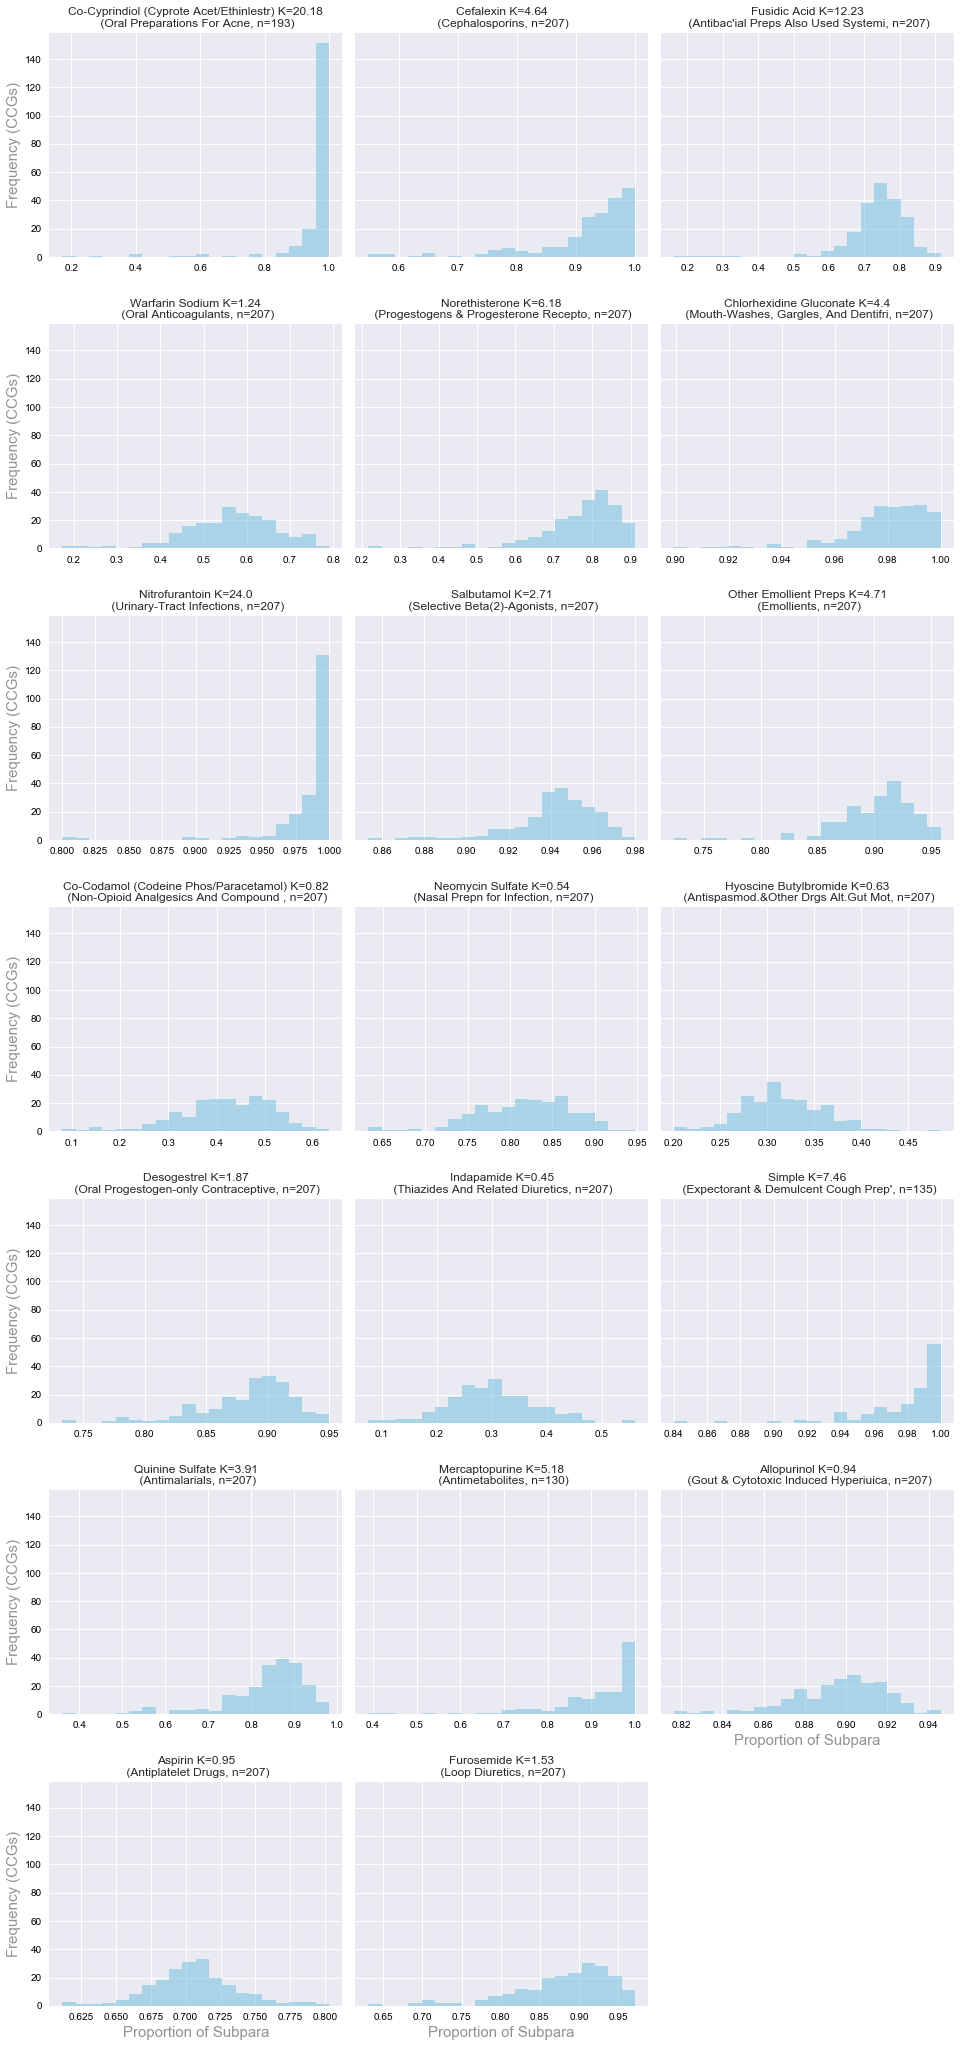

In [66]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with largest ratio of 95-97th percentiles to 50-95th percentiles

In [70]:
smy2 = smy0
smy2["95-97"] = smy2[0.97]-smy2[0.95]
smy2["50-95"] = smy2[0.95]-smy2[0.5]
smy2["ratio2"] = smy2["95-97"]/smy2["50-95"]

# this outputs some with very narrow range, so limit to at lest 1%:
smy2 = smy2.loc[smy2["95-97"]>0.01].sort_values(by="ratio2",ascending=False).reset_index().head(20)
smy2 = smy2[["chemical","ratio2"]].merge(df4, on="chemical")
smy2


chemical    ratio2               chemical name  subpara  \
0   0106040J0  2.406046         Magnesium Hydroxide  0106040   
1   0402010S0  1.804282     Promazine Hydrochloride  0402010   
2   1001022Y0  1.184107  Triamcinolone Hexacetonide  1001022   
3   1306020J0  0.829108                Isotretinoin  1306020   
4   0105010D0  0.793457          Balsalazide Sodium  0105010   
5   0401020T0  0.775810                    Oxazepam  0401020   
6   100302010  0.761926                  Ketoprofen  1003020   
7   0601011P0  0.748109           Insulin Glulisine  0601011   
8   0101010F0  0.745605         Magnesium Carbonate  0101010   
9   0301040R0  0.705329                  Salbutamol  0301040   
10  090401090  0.697677                Maltodextrin  0904010   
11  1103010Y0  0.646969                   Ofloxacin  1103010   
12  0103050R0  0.641177                Pantoprazole  0103050   
13  0803042R0  0.628028                   Degarelix  0803042   
14  0203020R0  0.616192   Propafenone Hydrochloride  0203020   
15  0501070T0  0.593056                 Teicoplanin  0501070   
16  1002020T0  0.584337    Tizanidine Hydrochloride  1002020   
17  0803042S0  0.583852        Triptorelin Embonate  0803042   
18  1310012K0  0.565699               Metronidazole  1310012   
19  0604012S0  0.552834                Progesterone  0604012   

                                subpara name  num_total  num centile  count  \
0                          Osmotic Laxatives     6378.0          6.0  207.0   
1                        Antipsychotic Drugs    27754.0          7.0  207.0   
2            Local Corticosteroid Injections      520.0          4.0  206.0   
3                 Oral Preparations For Acne     1870.0          5.0  193.0   
4                           Aminosalicylates    12836.0          7.0  207.0   
5                                Anxiolytics    24188.0          7.0  207.0   
6   Rubefacients,Top NSAIDS,Capsaicin & Poul    56903.0          8.0  207.0   
7                      Short-Acting Insulins    21998.0          7.0  207.0   
8                    Antacids and Simeticone      119.0          3.0  192.0   
9       Compound Bronchodilator Preparations     5928.0          6.0  205.0   
10                   Foods For Special Diets     3086.0          5.0  207.0   
11                            Antibacterials     7279.0          6.0  207.0   
12                    Proton Pump Inhibitors   311211.0         10.0  207.0   
13   Prostate Cancer & Gonadorelin Analogues     3523.0          5.0  207.0   
14                    Drugs For  Arrhythmias     5295.0          6.0  207.0   
15                 Some Other Antibacterials      359.0          3.0  169.0   
16                 Skeletal Muscle Relaxants    28661.0          7.0  207.0   
17   Prostate Cancer & Gonadorelin Analogues     2292.0          5.0  207.0   
18  Antibac'ial Preps Also Used Systemically    75389.0          8.0  207.0   
19  Progestogens & Progesterone Receptor Mod    15697.0          7.0  207.0   

    median   min   max  range   std  kurtosis  skew  
0     0.00  0.00  0.06   0.06  0.01     30.70  5.47  
1     0.00  0.00  0.30   0.30  0.03     43.61  6.07  
2     0.00  0.00  0.05   0.05  0.01     36.07  5.75  
3     0.01  0.00  0.83   0.83  0.12     20.18  4.33  
4     0.02  0.00  0.13   0.13  0.02     13.59  3.18  
5     0.01  0.00  0.15   0.15  0.02     19.86  4.02  
6     0.02  0.00  0.34   0.34  0.04     25.41  4.66  
7     0.03  0.00  0.24   0.24  0.03     10.17  2.85  
8     0.00  0.00  0.19   0.19  0.02     66.74  7.53  
9     0.03  0.00  0.36   0.36  0.05     14.29  3.45  
10    0.00  0.00  0.09   0.09  0.01     19.92  4.12  
11    0.01  0.00  0.26   0.26  0.03     28.26  4.39  
12    0.02  0.01  0.13   0.13  0.02     16.57  3.71  
13    0.00  0.00  0.20   0.20  0.04     10.96  3.36  
14    0.02  0.00  0.11   0.11  0.02      7.44  2.33  
15    0.00  0.00  0.38   0.38  0.05     28.38  5.21  
16    0.08  0.02  0.27   0.25  0.04      3.39  1.48  
17    0.00  0.00  0.20   0.2

### Histograms for top chemicals by percentile ratio (95-97th)

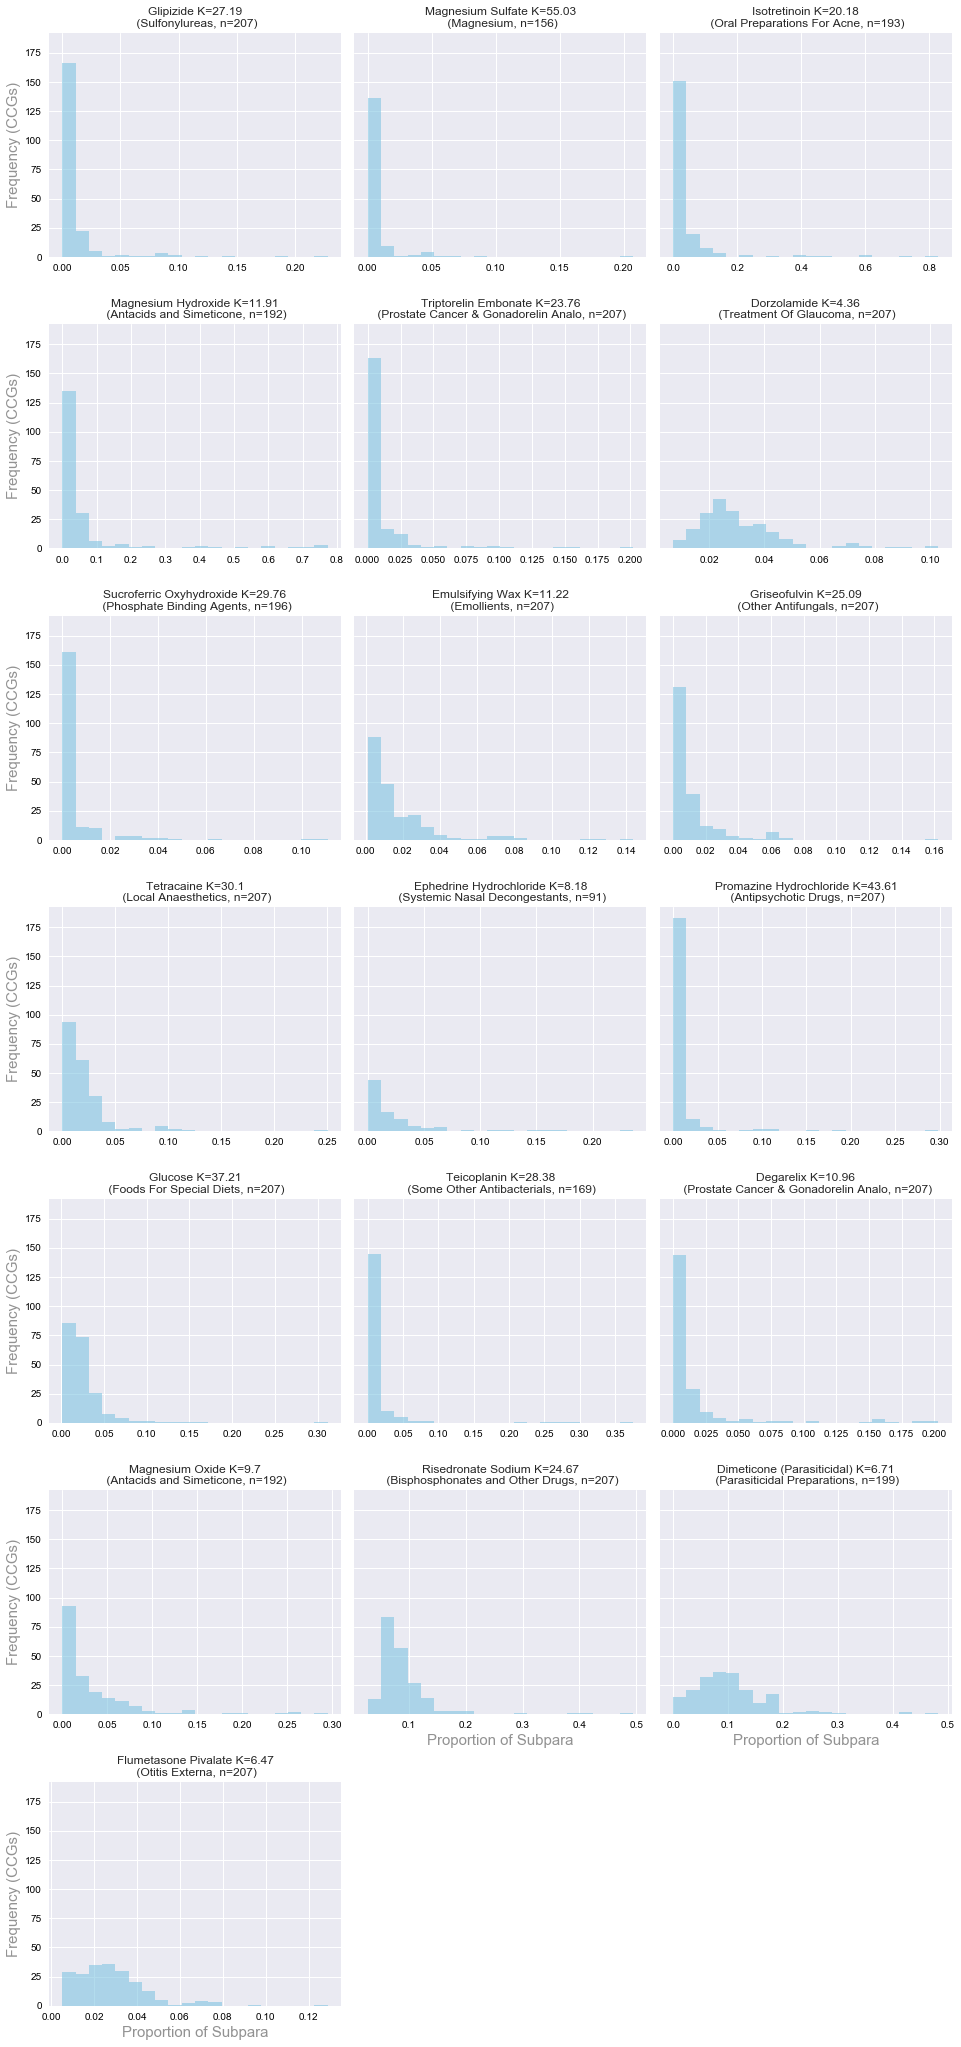

In [62]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy2
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with most CCGs outside IQR*1.5

In [100]:
smy3 = smy0

# Calculate IQR
smy3["IQR"] = smy3[0.75]-smy3[0.25] 

# Filter to those where range is at least 1%
smy3 = smy3.loc[smy3[0.97]-smy3[0.03]>0.01].reset_index()


# join back to dataset (unstacked)
dfx = data3.merge(smy3[["chemical","IQR",0.25,0.75]], on="chemical")

#Calculate 1.5* IQR applied to upper and lower quartiles
dfx["1.5xIQR_LQ"] = dfx[0.25]-(dfx["IQR"]/2)
dfx["1.5xIQR_UQ"] = dfx[0.75]+(dfx["IQR"]/2)

#Calculate difference between each ratio and the 1.5IQR limits
dfx["diff_LQ"] = dfx["ratio"]-dfx["1.5xIQR_LQ"]
dfx["diff_UQ"] = dfx["1.5xIQR_UQ"]-dfx["ratio"]

# For each chemical, count how many CCGs are outside 1.5*IQR range
smy3 = dfx.loc[(dfx["diff_UQ"]<0) | (dfx["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values(ascending=False).head(20)
smy3 = pd.DataFrame(smy3).reset_index().merge(df4, on="chemical").rename(columns={"pct":"pct count"})
smy3


chemical  pct count                         chemical name  subpara  \
0   0406000J0         52                           Domperidone  0406000   
1   1304000N0         52                Fluocinolone Acetonide  1304000   
2   0301011R0         52                            Salbutamol  0301011   
3   0105010B0         51                 Mesalazine (Systemic)  0105010   
4   1106000AB         51                 Dorzolamide & Timolol  1106000   
5   1106000Z0         50                               Timolol  1106000   
6   0802010G0         50                          Azathioprine  0802010   
7   020400040         50  Co-Tenidone (Atenolol/Chlortalidone)  0204000   
8   0105020A0         49                            Budesonide  0105020   
9   0206030Y0         49                            Ivabradine  0206030   
10  0406000L0         49                 Hyoscine Hydrobromide  0406000   
11  1306010C0         49                      Benzoyl Peroxide  1306010   
12  0604020K0         49                          Testosterone  0604020   
13  1310020L0         49                          Ketoconazole  1310020   
14  0906040B0         49                          Alfacalcidol  0906040   
15  1001010J0         49                             Ibuprofen  1001010   
16  0406000A0         49                              Hyoscine  0406000   
17  0206020A0         49                            Amlodipine  0206020   
18  1001010N0         48                        Mefenamic Acid  1001010   
19  0402010AB         48                            Quetiapine  0402010   

                             subpara name  num_total  num centile  count  \
0        Drugs Used In Nausea And Vertigo   123185.0          9.0  207.0   
1                 Topical Corticosteroids    26260.0          7.0  207.0   
2              Selective Beta(2)-Agonists  5304937.0         10.0  207.0   
3                        Aminosalicylates   359024.0         10.0  207.0   
4                   Treatment Of Glaucoma   166095.0          9.0  207.0   
5                   Treatment Of Glaucoma   129411.0          9.0  207.0   
6    Antiproliferative Immunosuppressants   214604.0          9.0  207.0   
7        Beta-Adrenoceptor Blocking Drugs    49159.0          8.0  207.0   
8                         Corticosteroids    13397.0          7.0  192.0   
9                 Other Antianginal Drugs   113719.0          9.0  207.0   
10       Drugs Used In Nausea And Vertigo    12114.0          7.0  207.0   
11          Topical Preparations For Acne    32906.0          8.0  207.0   
12      Male Sex Hormones And Antagonists    60182.0          8.0  207.0   
13                Antifungal Preparations    16626.0          7.0  207.0   
14                              Vitamin D   206905.0          9.0  207.0   
15  Non-Steroidal Anti-Inflammatory Drugs   566044.0         10.0  207.0   
16       Drugs Used In Nausea And Vertigo    36134.0          8.0  207.0   
17               Calcium-Channel Blockers  6994420.0         10.0  207.0   
18  Non-Steroidal Anti-Inflammatory Drugs    68120.0          8.0  207.0   
19                    Antipsychotic Drugs   820545.0         10.0  207.0   

    median   min   max  range   std  kurtosis  skew  
0     0.08  0.03  0.16   0.13  0.02      0.81  0.73  
1     0.01  0.00  0.05   0.05  0.01     29.02  4.05  
2     0.95  0.85  0.98   0.13  0.02      2.71 -1.33  
3     0.63  0.36  0.86   0.50  0.08      0.21 -0.10  
4     0.07  0.02  0.13   0.11  0.02     -0.24  0.49  
5     0.05  0.02  0.11   0.10  0.02      0.14  0.42  
6     0.83  0.64  1.00   0.36  0.08     -0.11  0.08  
7     0.00  0.00  0.03   0.03  0.00     11.09  2.35  
8     0.46  0.14  0.84   0.70  0.13     -0.22  0.11  
9     0.17  0.06  0.48   0.42  0.08      1.33  1.08  
10    0.01  0.00  0.03   0.03  0.00      2.65  1.45  
11    0.07  0.03  0.23   0.20  0.03      4.89  1.79  
12    0.06  0.01  0.20   0.18  0.03      3.55  1.59  
13    0.03  0.01  0.10   0.09  0.01      2.78  1.22  
14    0.03  0.01  0.07

### Histograms for top 20 chemicals with most CCGs outside 1.5x IQR

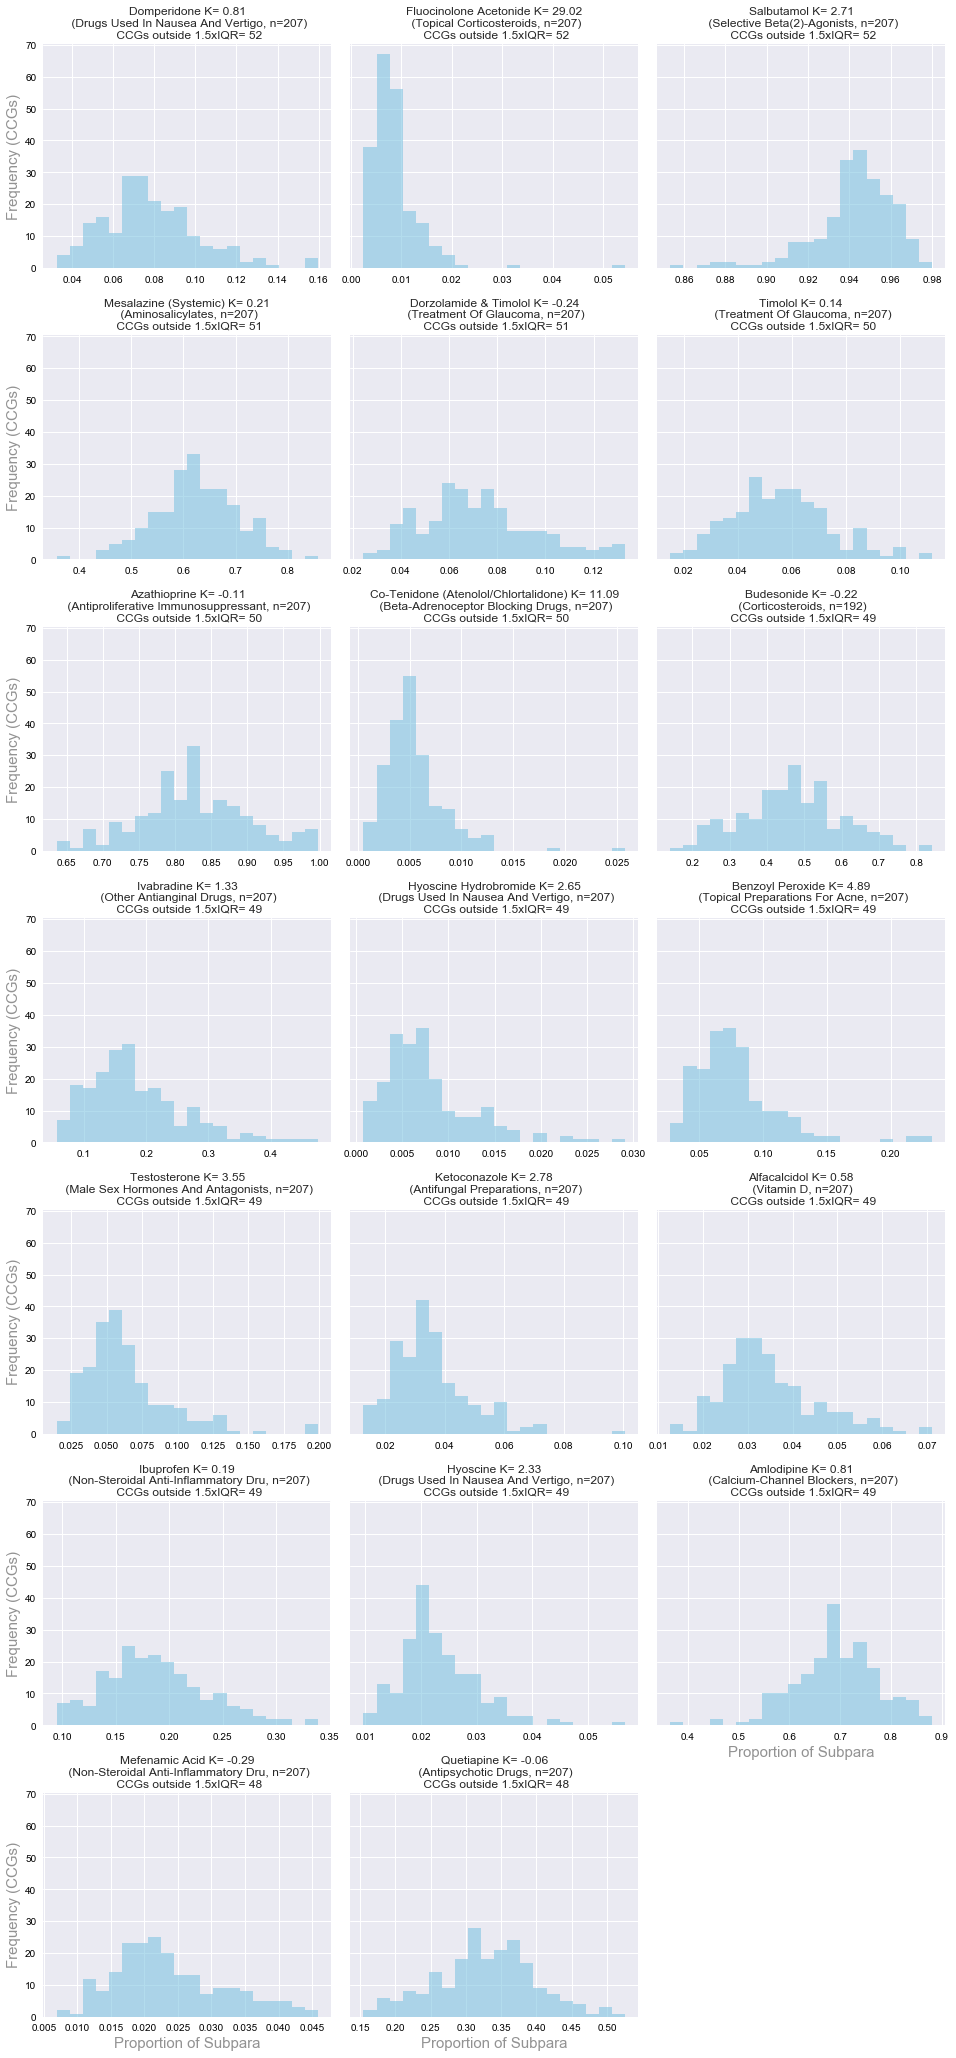

In [102]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy3
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside 1.5xIQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with with fewest no of CCGs outside IQR

In [107]:

dfx2 = dfx 
# note - filter already applied: 3-97 centile range >0.1. 

#Calculate difference between each ratio and the IQR limits
dfx2["diff_LQ"] = dfx2["ratio"]-dfx2[0.25]
dfx2["diff_UQ"] = dfx2[0.75]-dfx2["ratio"]
dfx2
# For each chemical, count how many CCGs are outside IQR range
smy4 = dfx2.loc[(dfx["diff_UQ"]<0) | (dfx2["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values().head(20)
smy4 = pd.DataFrame(smy4).reset_index().merge(df4, on="chemical").rename(columns={"pct":"pct count"})
smy4


chemical  pct count                  chemical name  subpara  \
0   0906024N0         11       Pyridoxine Hydrochloride  0906024   
1   0310000N0         23  Pseudoephedrine Hydrochloride  0310000   
2   0906031C0         25                  Ascorbic Acid  0906031   
3   1501030H0         27          Hyoscine Hydrobromide  1501030   
4   1501030G0         27         Glycopyrronium Bromide  1501030   
5   0801050P0         29               Hydroxycarbamide  0801050   
6   0605010G0         31              Clomifene Citrate  0605010   
7   0605010S0         31                     Somatropin  0605010   
8   0409030P0         33                      Piracetam  0409030   
9   0409030C0         33                  Tetrabenazine  0409030   
10  0409030R0         33                       Riluzole  0409030   
11  0801030P0         33                   Methotrexate  0801030   
12  0801030L0         33                 Mercaptopurine  0801030   
13  0906050T0         34             Tocopheryl Acetate  0906050   
14  0906050P0         34                      Vitamin E  0906050   
15  0309020D0         34                         Simple  0309020   
16  1203050A0         35              Artificial Saliva  1203050   
17  1203050P0         35      Pilocarpine Hydrochloride  1203050   

                                subpara name  num_total  num centile  count  \
0              Pyridoxine Hydrochloride (B6)    27446.0          7.0  186.0   
1               Systemic Nasal Decongestants    11630.0          6.0   91.0   
2                  Vitamin C (Ascorbic Acid)    34954.0          8.0  185.0   
3                       Antimuscarinic Drugs     5035.0          6.0  108.0   
4                       Antimuscarinic Drugs    14241.0          7.0  108.0   
5                 Other Antineoplastic Drugs    21908.0          7.0  126.0   
6   Hypothalamic&Ant Pituit Hormone&Antioest      960.0          4.0  124.0   
7   Hypothalamic&Ant Pituit Hormone&Antioest    13407.0          7.0  124.0   
8   Essentialtremor,Chorea,Tics&Reldisorders     1724.0          5.0  132.0   
9   Essentialtremor,Chorea,Tics&Reldisorders     6521.0          6.0  132.0   
10  Essentialtremor,Chorea,Tics&Reldisorders     4078.0          5.0  132.0   
11                           Antimetabolites     1513.0          5.0  130.0   
12                           Antimetabolites    14263.0          7.0  130.0   
13                                 Vitamin E     3045.0          5.0  136.0   
14                                 Vitamin E     9919.0          6.0  136.0   
15      Expectorant & Demulcent Cough Prep's    31678.0          7.0  135.0   
16                    Treatment Of Dry Mouth     8767.0          6.0  139.0   
17                    Treatment Of Dry Mouth     2905.0          5.0  139.0   

    median   min   max  range   std  kurtosis  skew  
0     1.00  0.95  1.00   0.05  0.00     48.27 -6.35  
1     0.98  0.76  1.00   0.24  0.04      5.86 -2.24  
2     1.00  0.84  1.00   0.16  0.02     47.02 -6.74  
3     0.03  0.00  1.00   1.00  0.34      0.17  1.35  
4     0.96  0.00  1.00   1.00  0.34      0.17 -1.34  
5     1.00  0.94  1.00   0.06  0.01     29.94 -5.06  
6     0.04  0.00  0.78   0.78  0.11     16.20  3.52  
7     0.93  0.17  1.00   0.83  0.12     13.68 -3.09  
8     0.11  0.00  0.54   0.54  0.12      1.16  1.20  
9     0.53  0.06  0.98   0.91  0.17      0.13 -0.15  
10    0.32  0.00  0.73   0.73  0.16     -0.18 -0.01  
11    0.05  0.00  0.61   0.61  0.11      5.21  2.07  
12    0.94  0.39  1.00   0.61  0.11      5.18 -2.06  
13    0.23  0.01  0.56   0.55  0.11      0.10  0.50  
14    0.73  0.44  0.94   0.51  0.11     -0.34 -0.35  
15    0.99  0.84  1.00   0.16  0.03      7.46 -2.35  
16    0.64  0.24  0.94   0.70  0.14     -0.38 -0.31  
17    0.19  0.02  0.65   0.63  0.12      0.89  0.95

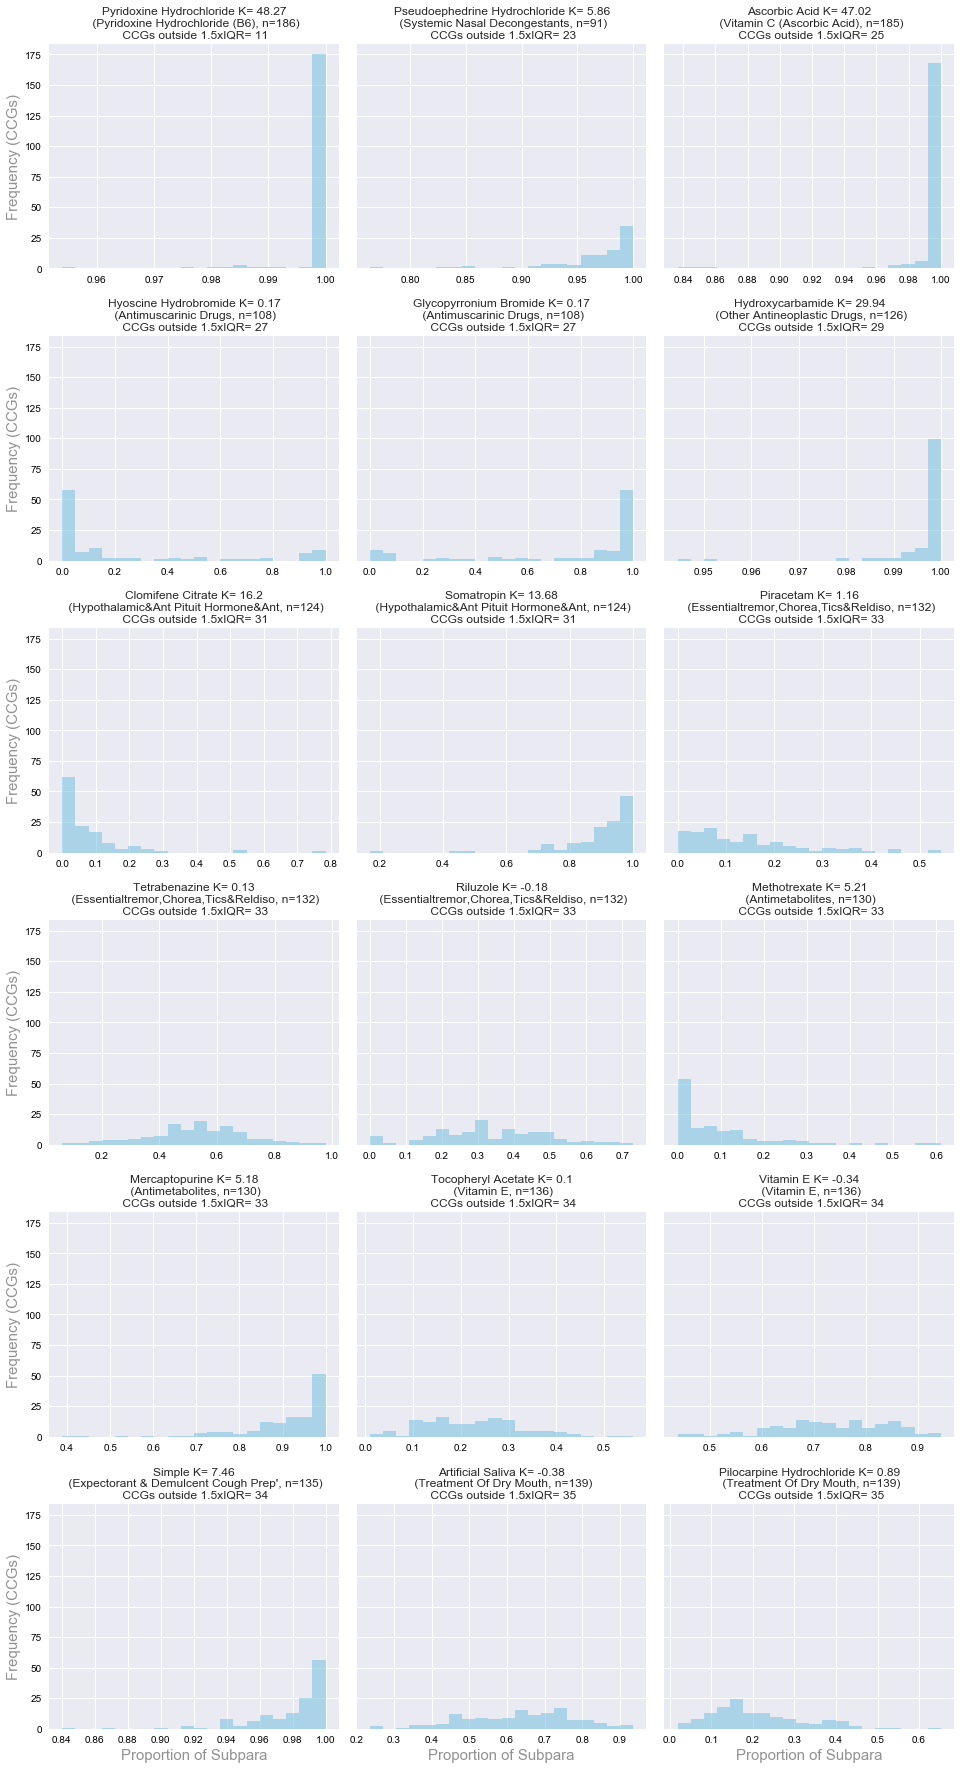

In [108]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy4
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside 1.5xIQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with with 5th CCG at X times IQR from median, ranked by X

In [119]:
smy5 = smy0

# Calculate IQR
smy5["IQR"] = smy5[0.75]-smy5[0.25] 

smy5["5-50"] = smy5[0.5]-smy5[0.05]
smy5["50-95"] = smy5[0.95]-smy5[0.5]
smy5["ratio1"] = (smy5["5-50"]/smy5["IQR"]).round(2)
smy5["ratio2"] = (smy5["50-95"]/smy5["IQR"]).round(2)

# this outputs some with very narrow range, so limit to at lest 1%:
# lower percentiles
smy5a = smy5.loc[smy5[0.97]-smy5[0.03]>0.01].sort_values(by="ratio1",ascending=False).reset_index().head(20)
smy5a = smy5a[["chemical","ratio1"]].merge(df4, on="chemical").rename(columns={"ratio1":"percentile ratio"})

# upper percentiles
smy5b = smy5.loc[smy5[0.97]-smy5[0.03]>0.01].sort_values(by="ratio2",ascending=False).reset_index().head(20)
smy5b = smy5b[["chemical","ratio2"]].merge(df4, on="chemical").rename(columns={"ratio2":"percentile ratio"})

smy5c = smy5a.append(smy5b)
smy5c

chemical  percentile ratio                            chemical name  \
0   0906031C0               inf                            Ascorbic Acid   
1   0801050P0               inf                         Hydroxycarbamide   
2   0906024N0               inf                 Pyridoxine Hydrochloride   
3   1306020C0          6.640000  Co-Cyprindiol (Cyprote Acet/Ethinlestr)   
4   1002010Q0          4.620000                   Pyridostigmine Bromide   
5   0906027G0          4.490000                       Vitamin B Compound   
6   0502050C0          4.120000                Terbinafine Hydrochloride   
7   1312000C0          4.020000                       Aluminium Chloride   
8   0902013S0          3.610000                       Sodium Bicarbonate   
9   1501030G0          3.250000                   Glycopyrronium Bromide   
10  0501130R0          3.120000                           Nitrofurantoin   
11  0601021M0          3.020000                               Gliclazide   
12  1311020L0          3.000000                  Chlorhexidine Gluconate   
13  0902011U0          2.790000                       Potassium Chloride   
14  0501021L0          2.760000                                Cefalexin   
15  120101050          2.580000                            Dexamethasone   
16  0310000N0          2.510000            Pseudoephedrine Hydrochloride   
17  0504010Y0          2.420000                          Quinine Sulfate   
18  1502010J0          2.360000                  Lidocaine Hydrochloride   
0   1502010P0               inf                Mepivacaine Hydrochloride   
1   1203040N0               inf                          Sodium Benzoate   
2   0309010L0               inf            Dextromethorphan Hydrobromide   
3   0309020I0               inf                                   Squill   
4   0410030D0               inf                 Lofexidine Hydrochloride   
5   0501070M0               inf                             Fusidic Acid   
6   0501070T0               inf                              Teicoplanin   
7   0101010F0               inf                      Magnesium Carbonate   
8   0206040AF               inf               Nicotinic Acid Derivatives   
9   0905013N0               inf                        Magnesium Sulfate   
10  0905013P0               inf                        Magnesium Lactate   
11  0905022W0               inf                 Sucroferric Oxyhydroxide   
12  090603100               inf    Other Vitamin C (Ascorbic Acid) Preps   
13  1001022Y0               inf               Triamcinolone Hexacetonide   
14  0605010T0               inf                           Tetracosactide   
15  1310011AA               inf                              Retapamulin   
16  0501021B0         14.500000                               Cefadroxil   
17  1404000H0         12.180000                                Influenza   
18  0803042S0          9.920000                     Triptorelin Embonate   

    subpara                              subpara name  num_total  num centile  \
0   0906031                 Vitamin C (Ascorbic Acid)    34954.0          8.0   
1   0801050                Other Antineoplastic Drugs    21908.0          7.0   
2   0906024             Pyridoxine Hydrochloride (B6)    27446.0          7.0   
3   1306020                Oral Preparations For Acne    30542.0          7.0   
4   1002010  Dgs Which Enhance Neuromus'ar Transmi'on    13597.0          7.0   
5   0906027                        Vitamin B Compound   563923.0         10.0   
6   0502050                         Other Antifungals   117781.0          9.0   
7   1312000                           Antiperspirants    18330.0          7.0   
8   0902013                          Oral Bicarbonate   109311.0          9.0   
9   1501030                      Antimuscarinic Drugs    14241.0          7.0   
10  0501130                  Urinary-Tract Infections   827882.0         10.0   
11  0601021                             Sulfonylureas  1845588.0    

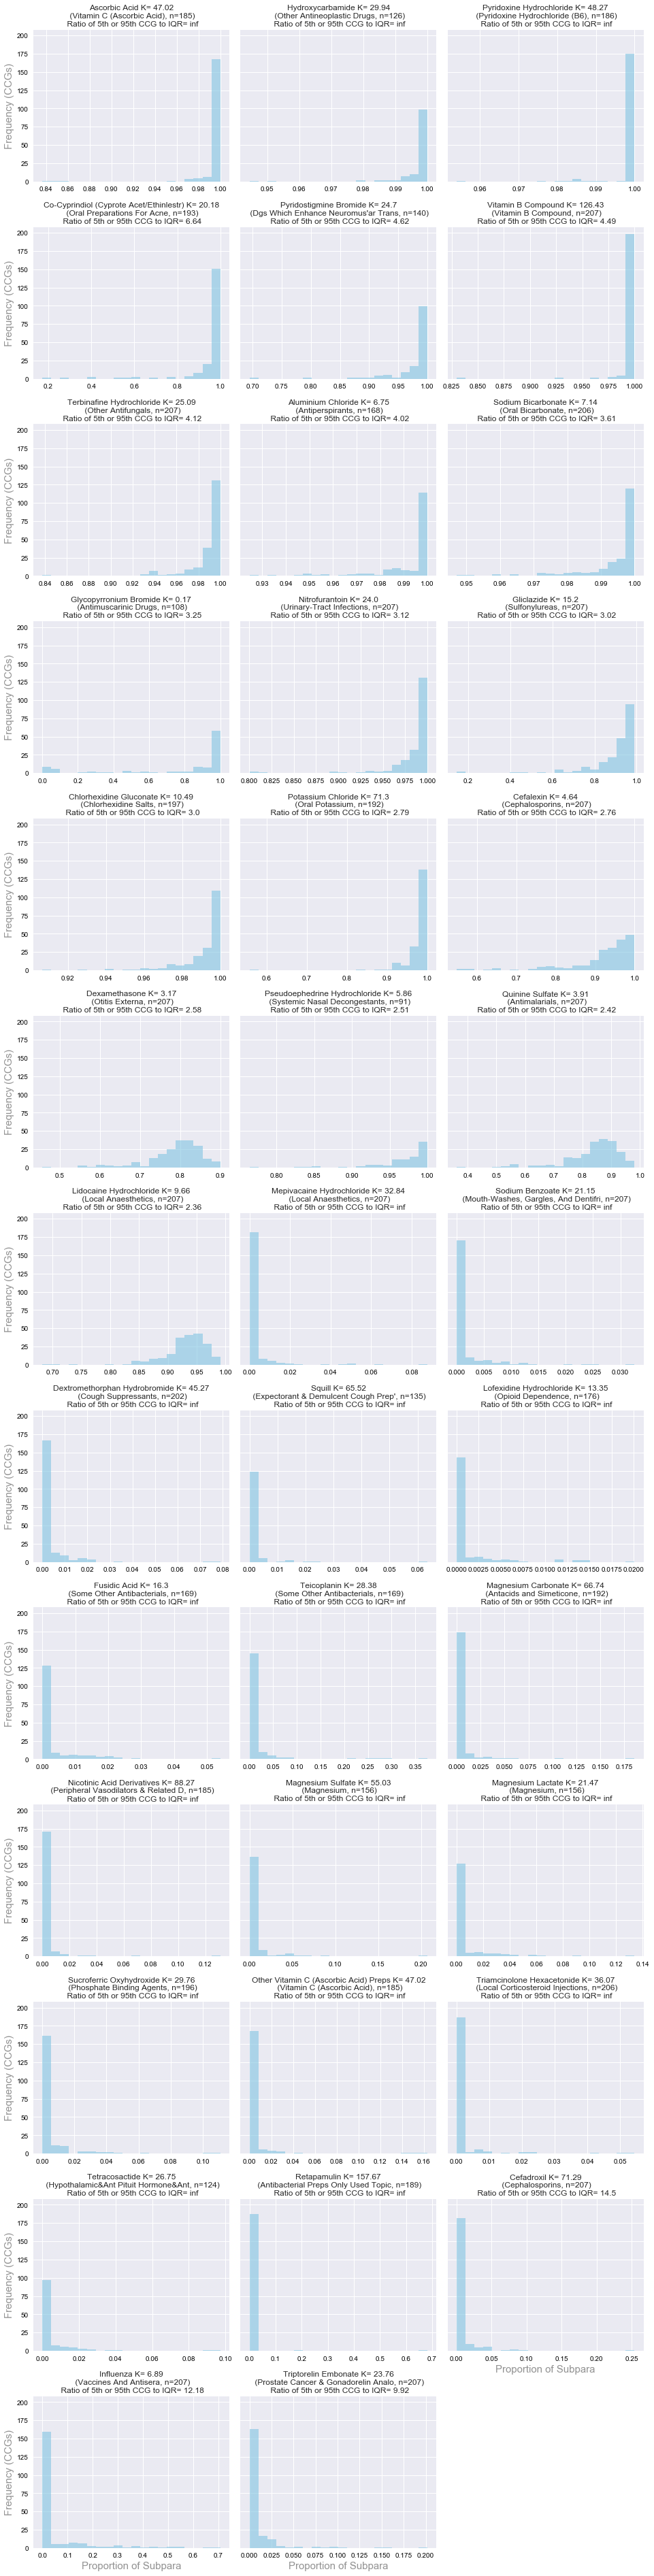

In [120]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy5c
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","percentile ratio"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","percentile ratio"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Ratio of 5th or 95th CCG to IQR= "+titles["percentile ratio"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

- how many times chem appear in top 20s
Chemicals where 75% of ccgs prescribe 0 but the total nationally is > X items over a year, ranked by X
Chemical/par 5th CCG is at X times IQR from median, rank by X

### Chemicals where 75% of CCGs prescribe 0 but the total nationally is > X items over 3mo period, ranked by X

In [144]:
smy6 = pd.DataFrame(data3.loc[data3.num==0].groupby("chemical")["pct"].count()).reset_index()
#ct = pd.DataFrame(data3.groupby("chemical")["num"].count()).reset_index()
smy6 =smy6.merge(df4.reset_index(), on="chemical").drop("index",axis=1).rename(columns={"pct":"pct count"})
#smy6 =smy6.merge(ct.reset_index(), on="chemical")
smy6["ratio non-p"] = smy6["pct count"]/smy6["count"]
smy6 = smy6.loc[smy6["ratio non-p"]>0.75].sort_values(by="num_total",ascending=False).head(20)
smy6

chemical  pct count                           chemical name  subpara  \
529  1502010P0        166               Mepivacaine Hydrochloride  1502010   
502  1310011AA        164                             Retapamulin  1310011   
408  1001022Y0        173              Triamcinolone Hexacetonide  1001022   
244  0501070T0        128                             Teicoplanin  0501070   
129  0401010AC        158                          Sodium Oxybate  0401010   
394  0906040P0        168                            Paricalcitol  0906040   
387  0905022W0        156                Sucroferric Oxyhydroxide  0905022   
172  0406000M0        157               Granisetron Hydrochloride  0406000   
99   0208020N0        160                             Phenindione  0208020   
12   0102000H0        160                    Belladonna Alkaloids  0102000   
211  0409010S0        170                               Tolcapone  0409010   
29   0106040X0        162                           Macrogol 4000  0106040   
225  0410030D0        140                Lofexidine Hydrochloride  0410030   
518  1404000AP        197                                     NaN  1404000   
183  040702020        167  Morphine Tartrate & Cyclizine Tartrate  0407020   
82   0206020B0        168             Trimetazidine Hydrochloride  0206020   
77   0205052AD        158                    Azilsartan Medoxomil  0205052   
123  0309010L0        155           Dextromethorphan Hydrobromide  0309010   
332  0803041AA        188                             Fulvestrant  0803041   
176  040701000        167        Other Non-Opioid Analgesic Preps  0407010   

                                 subpara name  num_total  num centile  count  \
529                        Local Anaesthetics     1046.0          4.0  207.0   
502   Antibacterial Preps Only Used Topically      622.0          4.0  189.0   
408           Local Corticosteroid Injections      520.0          4.0  206.0   
244                 Some Other Antibacterials      359.0          3.0  169.0   
129                                 Hypnotics      278.0          3.0  207.0   
394                                 Vitamin D      257.0          3.0  207.0   
387                  Phosphate Binding Agents      230.0          3.0  196.0   
172          Drugs Used In Nausea And Vertigo      214.0          3.0  207.0   
99                        Oral Anticoagulants      212.0          3.0  207.0   
12   Antispasmod.&Other Drgs Alt.Gut Motility      208.0          3.0  207.0   
211   Dopaminergic Drugs Used In Parkinsonism      208.0          3.0  207.0   
29                          Osmotic Laxatives      175.0          3.0  207.0   
225                         Opioid Dependence      175.0          3.0  176.0   
518                     Vaccines And Antisera      155.0          3.0  207.0   
183                         Opioid Analgesics      149.0          3.0  207.0   
82                   Calcium-Channel Blockers      147.0          3.0  207.0   
77        Angiotensin-II Receptor Antagonists      142.0          3.0  207.0   
123                        Cough Suppressants      135.0          3.0  202.0   
332                             Breast Cancer      132.0          3.0  207.0   
176   Non-Opioid Analgesics And Compound Prep      126.0          3.0  207.0   

     median  min   max  range   std  kurtosis   skew  ratio non-p  
529     0.0  0.0  0.09   0.09  0.01     32.84   5.39     0.801932  
502     0.0  0.0  0.68   0.68  0.05    157.67  12.36     0.867725  
408     0.0  0.0  0.05   0.05  0.01     36.07   5.75     0.839806  
244     0.0  0.0  0.38   0.38  0.05     28.38   5.21     0.757396  
129     0.0  0.0  0.00   0.00  0.00     27.63   4.62     0.763285  
394     0.0  0.0  0.00   0.00  0.00     41.06   5.70     0.811594  
387     0.0  0.0  0.11   0.11  0.01     29.76   4.99     0.795918  
172     0.0  0.0  0.00   0.00  0.00     46.42   5.85     0.758454  
99      0.0  0.0  0.00   0.00  0.00     17.36   3.93     0.772947  
12    

## Compile results

In [151]:
smy["s1"] = 1
smy2["s2"] = 1
smy3["s3"] = 1
smy4["s4"] = 1
smy5c["s5"] = 1
smy6["s6"] = 1

sc = pd.merge(rc, smy, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy5c, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy6, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")

sc = sc.fillna(0)
sc["score"] = sc["R"]+sc["K"]+sc["Sk"]+sc["SD"]+sc["s1"]+sc["s2"]+sc["s3"]+sc["s4"]+sc["s5"]+sc["s6"]
sc = sc.sort_values(by=["score","kurtosis","range"],ascending=False)
sc


links = sc
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

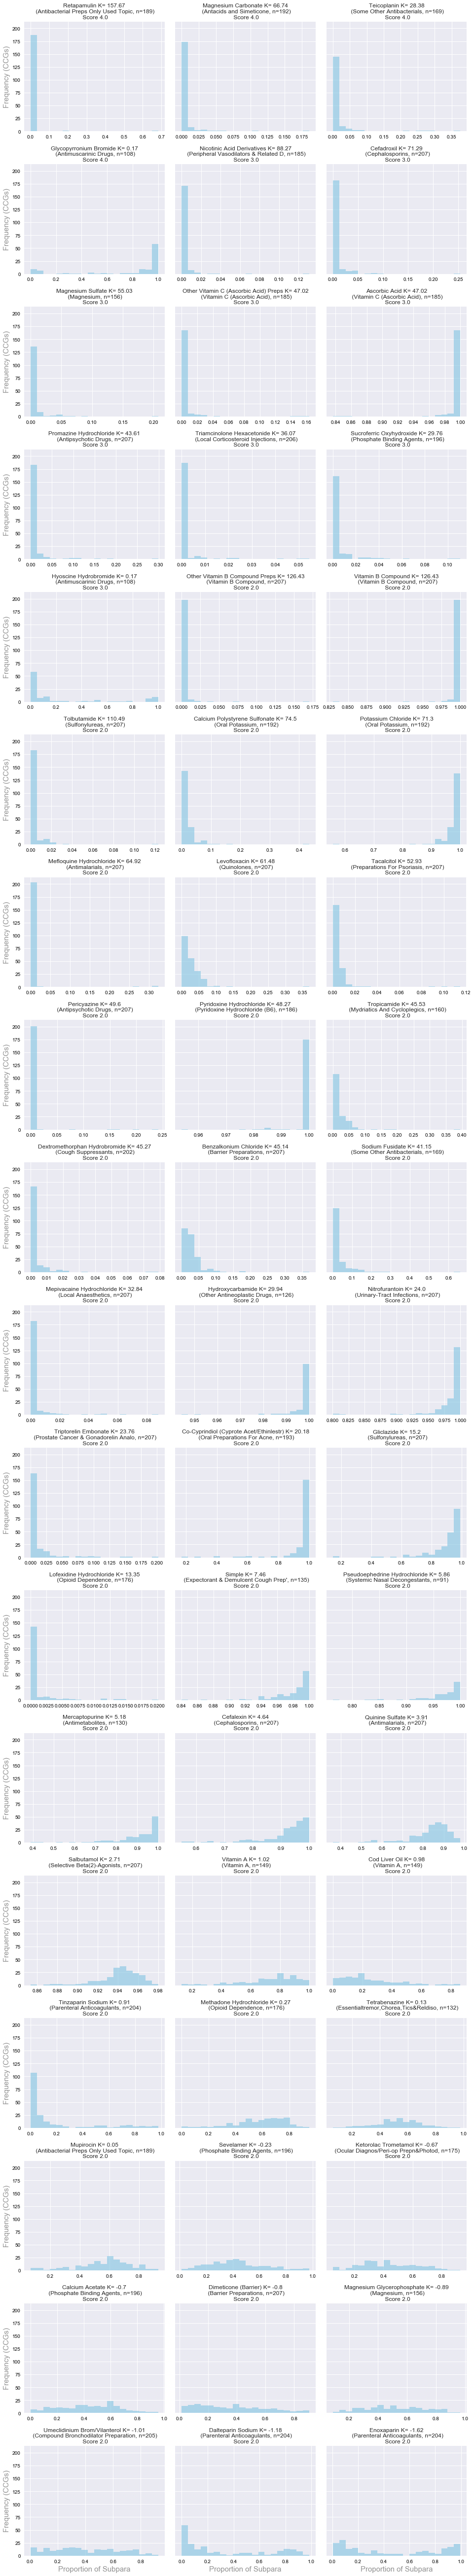

In [150]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = sc.loc[sc["score"]>1]
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","score"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","score"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Score "+titles["score"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()